### 6. 1 seed vs. 1000 samples

#### 6.1. properties

SMILES vae prop obj ws 0.5

In [ ]:
z_calc = []
for j in range(1000):
    eps = torch.randn_like(torch.tensor(whole_data_df['mu'][5]))
    z = torch.tensor(whole_data_df['mu'][5]) + (torch.tensor(whole_data_df['logvar'][5]) / 2).exp() * eps
    z_calc.append(z)
z_calc = torch.stack(z_calc)

sampled = model.sample(n_batch=z_calc.shape[0], z=z_calc, test=False)
sampled = np.array(sampled).squeeze()
sampled_arg = model.sample(n_batch=z_calc.shape[0], z=z_calc, test=True)
sampled_arg = np.array(sampled_arg).squeeze()

In [ ]:
seed =model.sample(n_batch=1, z=torch.tensor(whole_data_df['mu'][5].reshape(1, -1)), test=True)
print(f'sampled temp unique: {len(set(sampled))}')
print(f'seed in sampled_temp: {seed[0] in set(sampled)}')
print('\n')
print(f'sampled_arg unique: {len(set(sampled_arg))}')
print(f'seed in sampled_arg: {seed[0] in set(sampled_arg)}')
print(seed[0])
set(sampled_arg)

sampled temp unique: 1000
seed in sampled_temp: False


sampled_arg unique: 9
seed in sampled_arg: True
CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCC2C)cc1


{'CC(C)CC(=O)N1CCC(C(=O)Nc2ccccc2C(F)(F)F)CC1',
 'CC(C)CC(=O)N1CCC(C(=O)Nc2ccccc2C(N)=O)CC1',
 'CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCC2)cc1',
 'CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCC2C)cc1',
 'CC(C)CC(=O)Nc1ccc(C(=O)N2CCCCCC2)cc1',
 'CC(C)CC(=O)Nc1ccc(C(=O)Nc2cccc(C#N)c2)cc1',
 'CC(C)CC(=O)Nc1ccc(C(=O)Nc2cccc(C(N)=O)c2)cc1',
 'CC(C)CC(=O)Nc1ccc(C(=O)Nc2ccccc2)cc1',
 'CC(C)CC(=O)Nc1ccc(C(=O)Nc2ccccc2O)cc1'}

In [ ]:
sampled_temp_df = pd.DataFrame(sampled, columns=['gen_mol'])
sampled_temp_df['gen_romol'] = [get_mol(mol) for mol in sampled_temp_df['gen_mol']]
sampled_temp_df = sampled_temp_df.dropna(subset=['gen_romol'])
sampled_temp_df = sampled_temp_df.reset_index(drop=True)

sampled_temp_df['gen_logP'] = [logP(mol) for mol in sampled_temp_df['gen_romol']]
sampled_temp_df['gen_qed'] = [QED(mol) for mol in sampled_temp_df['gen_romol']]
sampled_temp_df['gen_SAS'] = [SA(mol) for mol in sampled_temp_df['gen_romol']]
sampled_temp_df['gen_obj'] = 5*sampled_temp_df['gen_qed'] - sampled_temp_df['gen_SAS']

In [ ]:
sampled_arg_df = pd.DataFrame(sampled_arg, columns=['gen_mol'])
sampled_arg_df['gen_romol'] = [get_mol(mol) for mol in sampled_arg_df['gen_mol']]
sampled_arg_df['gen_z'] = [point for point in z_calc.detach().cpu().numpy()]
sampled_arg_df = sampled_arg_df.dropna(subset=['gen_romol'])
sampled_arg_df = sampled_arg_df.reset_index(drop=True)

sampled_arg_df['gen_logP'] = [logP(mol) for mol in sampled_arg_df['gen_romol']]
sampled_arg_df['gen_qed'] = [QED(mol) for mol in sampled_arg_df['gen_romol']]
sampled_arg_df['gen_SAS'] = [SA(mol) for mol in sampled_arg_df['gen_romol']]
sampled_arg_df['gen_obj'] = 5*gen_df['gen_qed'] - sampled_arg_df['gen_SAS']

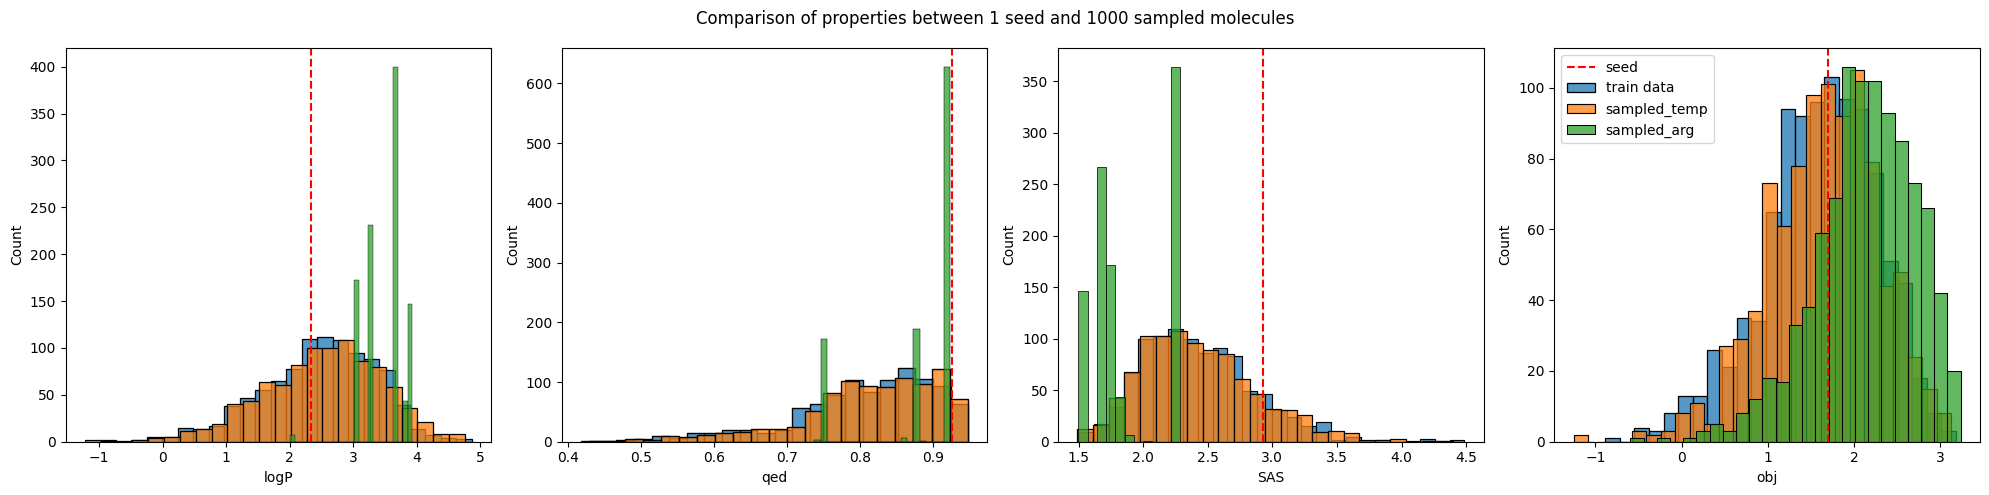

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.histplot(whole_data_df['logP'], ax=axs[0], label='train data')
sns.histplot(whole_data_df['qed'], ax=axs[1], label='train data')
sns.histplot(whole_data_df['SAS'], ax=axs[2], label='train data') 
sns.histplot(whole_data_df['obj'], ax=axs[3], label='train data')

sns.histplot(sampled_temp_df['gen_logP'], ax=axs[0], label='sampled_temp')
sns.histplot(sampled_temp_df['gen_qed'], ax=axs[1], label='sampled_temp')
sns.histplot(sampled_temp_df['gen_SAS'], ax=axs[2], label='sampled_temp')
sns.histplot(sampled_temp_df['gen_obj'], ax=axs[3], label='sampled_temp')

sns.histplot(sampled_arg_df['gen_logP'], ax=axs[0], label='sampled_arg')
sns.histplot(sampled_arg_df['gen_qed'], ax=axs[1], label='sampled_arg')
sns.histplot(sampled_arg_df['gen_SAS'], ax=axs[2], label='sampled_arg')
sns.histplot(sampled_arg_df['gen_obj'], ax=axs[3], label='sampled_arg')

axs[0].axvline(whole_data_df['logP'][5], color='r', linestyle='--', label='seed')
axs[1].axvline(whole_data_df['qed'][5], color='r', linestyle='--', label='seed')
axs[2].axvline(whole_data_df['SAS'][5], color='r', linestyle='--', label='seed')
axs[3].axvline(whole_data_df['obj'][5], color='r', linestyle='--', label='seed')

fig.suptitle('Comparison of properties between 1 seed and 1000 sampled molecules')
plt.tight_layout()
plt.legend()
plt.show()


#### 6.2. tanimoto similarity
Tanimoto similarity captures the similarity / overlaps of structures between two molecules

If tanimoto similarity = 1 : same molecule

In [ ]:
def calculate_tanomoto_similiarity(mol1, mol2):
    fp1 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol1), 2)
    fp2 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol2), 2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [ ]:
tanimotos = []
for i in range(len(sampled_temp_df)):
    tanimotos.append(calculate_tanomoto_similiarity(sampled_temp_df['gen_mol'][0], sampled_temp_df['gen_mol'][i]))

tanimotos = np.array(tanimotos)

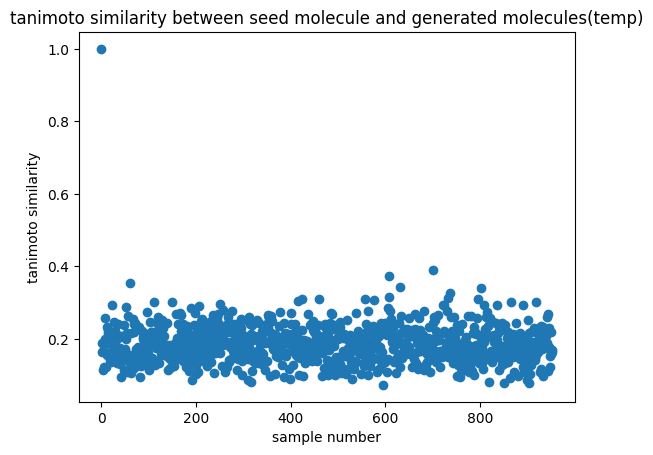

In [ ]:
# plot scatter plot of tanimoto similarity
plt.scatter(range(len(tanimotos)), tanimotos)
plt.xlabel('sample number')
plt.ylabel('tanimoto similarity')
plt.title('tanimoto similarity between seed molecule and generated molecules(temp)')
plt.show()